In [ ]:
# import os
# import sys
# import urllib3
# from urllib.parse import urlparse
# import pandas as pd
# import itertools
# import shutil

# from urllib3.util import Retry

# urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# classes = ["cat", "fish"]
# set_types = ["train", "test", "val"]

# def download_image(url, klass, data_type):
#     basename = os.path.basename(urlparse(url).path)
#     filename = "{}/{}/{}".format(data_type, klass, basename)
#     if not os.path.exists(filename):
#         try: 
#             http = urllib3.PoolManager(retries=Retry(connect=1, read=1, redirect=2))
#             with http.request("GET", url, preload_content=False) as resp, open(
#                 filename, "wb"
#             ) as out_file:
#                 if resp.status == 200:
#                     shutil.copyfileobj(resp, out_file)
#                 else:
#                     print("Error downloading {}".format(url))
#             resp.release_conn()
#         except:
#             print("Error downloading {}".format(url))


# if __name__ == "__main__":
#     if not os.path.exists("images.csv"):
#         print("Error: can't find images.csv!")
#         sys.exit(0)

#     # get args and create output directory
#     imagesDF = pd.read_csv("images.csv")

#     for set_type, klass in list(itertools.product(set_types, classes)):
#         path = "./{}/{}".format(set_type, klass)
#         if not os.path.exists(path):
#             print("Creating directory {}".format(path))
#             os.makedirs(path)

#     print("Downloading {} images".format(len(imagesDF)))

#     result = [
#         download_image(url, klass, data_type)
#         for url, klass, data_type in zip(
#             imagesDF["url"], imagesDF["class"], imagesDF["type"]
#         )
#     ]
#     sys.exit(0)

In [2]:
import torch
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES=True

In [3]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [4]:

transforms = transforms.Compose([
    transforms.Resize((64,64)), #масштабируем изображение в 64х64
    transforms.ToTensor(),#превращение в тензор
    #нормализуем данные вокруг среднего и отклонения
    #данные значения для всего ImageNet в целом
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

In [5]:
train_data_path = './train/'
train_data = datasets.ImageFolder(root=train_data_path, transform=transforms, is_valid_file=check_image)

In [6]:
val_data_path = './val/'
val_data = datasets.ImageFolder(root=val_data_path, transform=transforms, is_valid_file=check_image)

In [7]:
test_data_path = './test/'
test_data = datasets.ImageFolder(root=test_data_path, transform=transforms, is_valid_file=check_image)

In [8]:
import torch.utils.data as data
import torch.nn.functional as F

In [9]:
batch_size = 64
train_data_loader = data.DataLoader(train_data, batch_size=batch_size)
val_data_loader = data.DataLoader(val_data, batch_size=batch_size)
test_data_loader = data.DataLoader(test_data, batch_size=batch_size)


In [10]:
import torch.nn as nn
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(12288, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50, 2)
        
    def forward(self, x):
        x = x.reshape(-1, 12288)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
            
simple_net = SimpleNet()  

In [11]:
import torch.optim as optim
optimizer = optim.Adam(simple_net.parameters(), lr = 0.001)

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
    
            
simple_net.to(device)

SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [13]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
        
        
        
        

In [14]:
train(simple_net, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=5, device=device)
    

Epoch: 1, Training Loss: 2.80, Validation Loss: 4.99, accuracy = 0.36
Epoch: 2, Training Loss: 3.07, Validation Loss: 1.89, accuracy = 0.67
Epoch: 3, Training Loss: 1.31, Validation Loss: 0.94, accuracy = 0.59
Epoch: 4, Training Loss: 0.71, Validation Loss: 0.83, accuracy = 0.69
Epoch: 5, Training Loss: 0.54, Validation Loss: 0.66, accuracy = 0.69


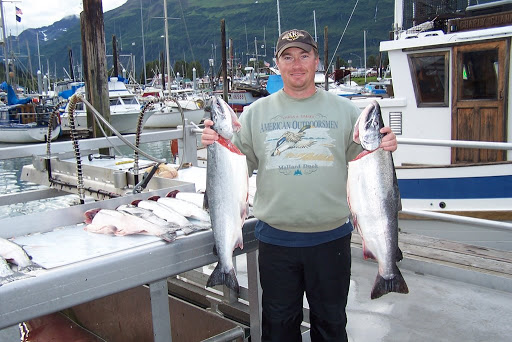

In [22]:
labels = ['cat','fish']
from IPython.display import display
img = Image.open("./val/fish/100_1422.JPG")
display(img)



In [23]:
img = transforms(img).to(device)
img = torch.unsqueeze(img, 0)

simple_net.eval()
prediction = F.softmax(simple_net(img), dim=1)
prediction = prediction.argmax()
print(labels[prediction]) 

fish


In [ ]:
# Сохранение модели
torch.save(simplenet, "/tmp/simplenet") 

In [ ]:
# Загрузка модели
simplenet = SimpleNet()
simplenet_state_dict = torch.load("/tmp/simplenet")
simplenet.load_state_dict(simplenet_state_dict)  